In [1]:
import Classes_and_functions
from Classes_and_functions import *

/home/firp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/firp/.local/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
writer = SummaryWriter()

## Dataset

In [3]:
train_datapath = "Datasets/Training_set"
val_datapath = "Datasets/Validation_set"
test_datapath = "Datasets/Test_set"

In [4]:
train_data = SonarDescriptorDatasetFull(train_datapath, None)
val_data = SonarDescriptorDatasetFull(val_datapath, train_data)
test_data = SonarDescriptorDatasetFull(test_datapath, train_data)

In [5]:
print("Training: " + str(len(train_data.imgs)))
print("Validation: " + str(len(val_data.imgs)))
print("Test: " + str(len(test_data.imgs)))

Training: 27915
Validation: 3573
Test: 3516


In [6]:
real_data = SonarDescriptorRealDataset(None, None)

In [7]:
print("Real: " + str(len(real_data.imgs)))

Real: 2182


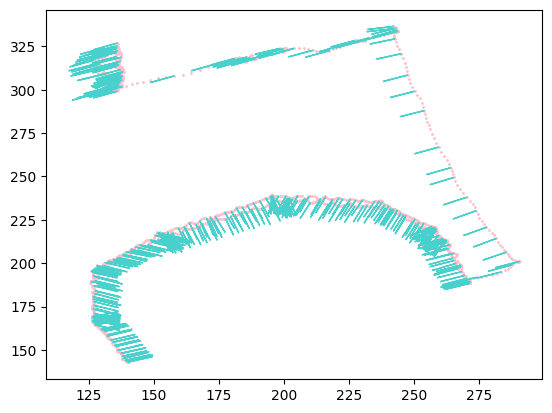

In [8]:
plt.scatter(real_data.poses[:, 0], real_data.poses[:, 1], c="pink", marker='o', linestyle='None', s =1)
for i in range(0, real_data.poses.shape[0], 5):
    q_x, q_y, q_Y_deg = real_data.poses[i, :]
    q_Y = (q_Y_deg+90)*np.pi/180
    q_Y %= 2*np.pi
    scatter_real_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)

In [9]:
q_pose = real_data.poses[700]

q_x, q_y, q_Y_deg = q_pose
q_pose = np.array([q_x, q_y, (90+q_Y_deg)%360])

gt_pose_idx = train_data.gtquery(q_x, q_y, q_Y_deg)

testpose: tensor(258.7900) tensor(216.2201) tensor(246.5887)
closest_index in poses tensor(11417)
XY distance: 0.9432758428580711 11417
yawdiff tensor(83.1507)
iou: 0.21741631336550551
yaw difference tensor(83.1507) deg
localization error:  0.094327584 meters


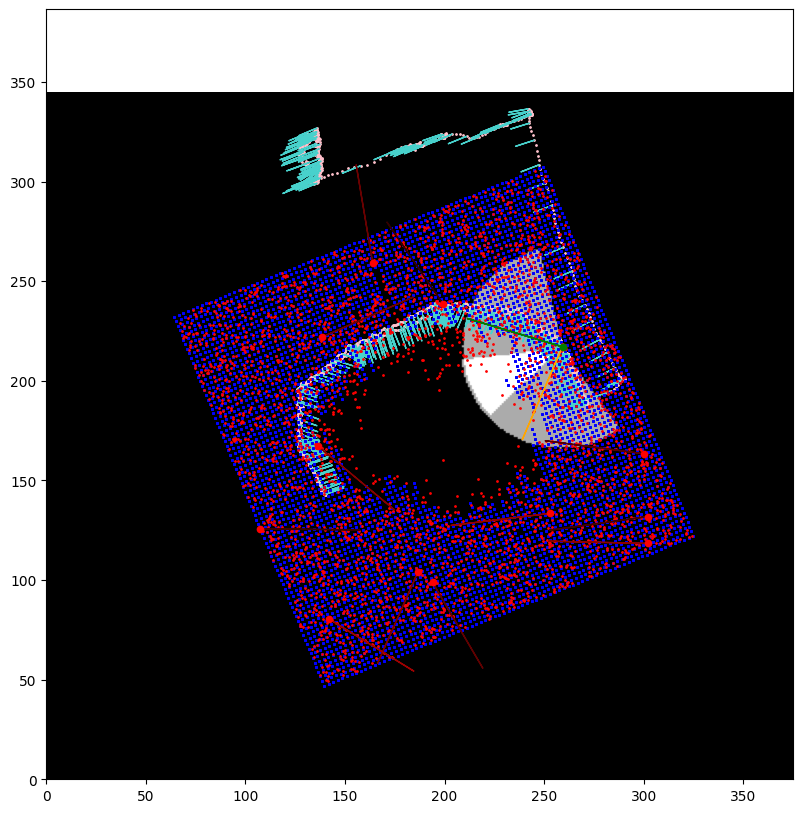

<Figure size 640x480 with 0 Axes>

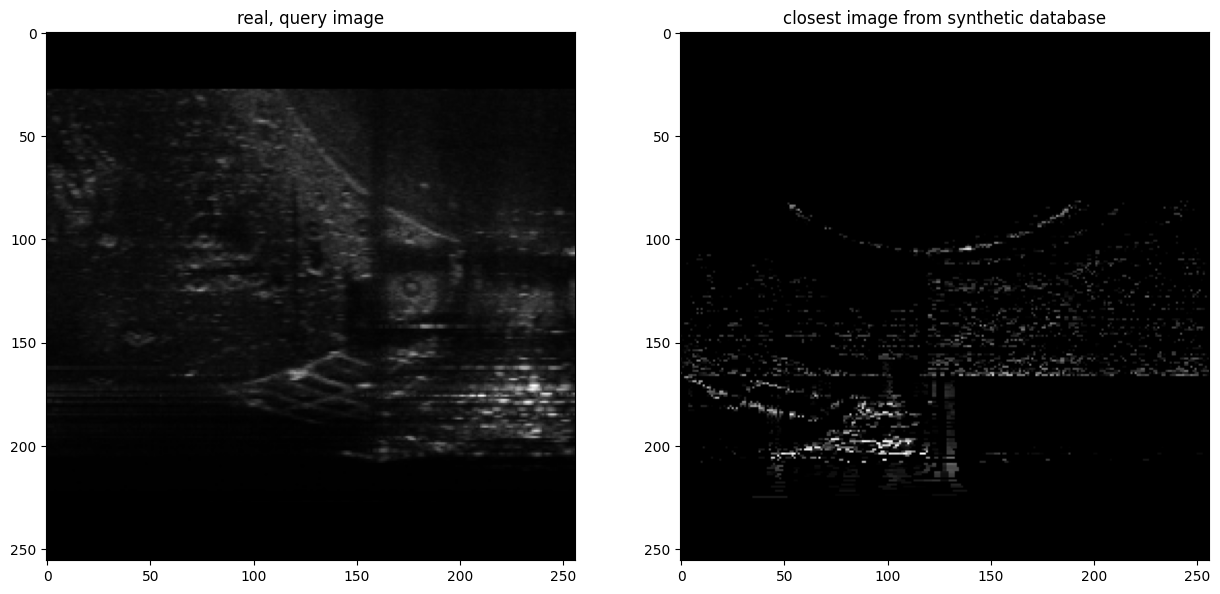

In [10]:
start_plot(train_data)
train_data.apply_random_rot = False

### plot real poses
plt.scatter(real_data.poses[:, 0], real_data.poses[:, 1], c="pink", marker='o', linestyle='None', s =1)
for i in range(0, 2000, 5):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)

plot_synth_poses_train(train_data, "blue")
plot_synth_poses_val(val_data, "red")

train_data.apply_random_rot = False

#### pick a random real image
realidx = 1062
realidx = 1379
realidx = 1387
realidx = random.randint(200, 500)
q_x, q_y, q_Y_deg = q_pose = real_data.poses[realidx]

### apply yaw transformation and draw orientation
q_Y_deg = (90+q_Y_deg)%360
q_Y = q_Y_deg * np.pi/180
q_pose = np.array([q_x, q_y, q_Y_deg])
scatter_orientation(q_x, q_y, q_Y, "orange", rad=50)

### apply yaw transformation to train data
q_pose2 = np.array([q_x, q_y, (90-q_Y_deg)%360])

### query ground truth synthetic database
gt_pose_idx = gtquery(train_data, q_x, q_y, (90-q_Y_deg)%360)

### draw synthetic train set beam
base = (gt_pose_idx//13)*13
cont = 0.2
for i in range(base, base+13):
    x3,y3, Y3, Y3_deg = parse_pose(train_data[i][2])
    scatter_orientation(x3, y3, Y3, [cont, 0, 0])
    scatter_point(x3, y3, "red")
    cont += 0.035

### pick closest train set data
train_closest = train_data[gt_pose_idx][2]

x2,y2, Y2, Y2_deg = parse_pose(train_closest)
scatter_orientation(x2, y2, Y2, "green")
scatter_point(x2, y2, "green")

### compute some metrics
mask3, iou = generate_interference_mask(x2, y2, Y2, Y2_deg, q_x, q_y, q_Y, q_Y_deg)
print("iou:", iou)
print("yaw difference", abs(Y2_deg-q_Y_deg), "deg")
print("localization error: ", np.linalg.norm(train_closest[:2]-q_pose2[:2], ord=2)/10, "meters")

#### draw interference
plt.imshow(mask3, cmap="gray")
    
### show images
plt.figure()
    
f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].set_title("real, query image")
axarr[1].set_title("closest image from synthetic database")

axarr[0].imshow(real_data[realidx][1].numpy()[0, :, :], cmap='gray')
axarr[1].imshow(train_data[gt_pose_idx][1].numpy()[0, :, :], cmap='gray')

In [11]:
batch = 2
train_dataloader = DataLoader(train_data, batch_size=batch, shuffle=True)

## Model

### Model instantiation

In [12]:
net = Model().cuda()
net.train()

optimizer = torch.optim.AdamW(net.parameters(), lr = 0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=len(train_data), gamma=0.8)

drop = torch.nn.Dropout(0.3).cuda()

In [13]:
locacriterion = torch.nn.CrossEntropyLoss().cuda()
recocriterion = torch.nn.MSELoss().cuda()

## Training Pipeline

### Train epochs

In [14]:
for epoch in range(1, 25):

    ## train
    train_data.apply_random_rot = True
    net.train()

    train_losses = []

    for idx, (image, gtimage, gtpose, _, _, mode) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        image = drop(image.cuda())
        gtimage = gtimage.cuda()
        mode = mode[:, None].cuda()
        
        embed, rec = net(image, reco=True)

        distmat  = torch.clamp(sonar_overlap_distance_matrix(gtpose, mode), 1e-4, 1).cuda()
        embedmat = torch.clamp(calcEmbedMatrix(embed), 0, 1)

        distmat, embedmat = mode*distmat, mode*embedmat
        
        loss_reco = recocriterion(rec[0], gtimage) + 0.125*recocriterion(rec[3], gtimage) + 0.25*recocriterion(rec[4], gtimage)
        loss_loca = locacriterion(distmat, embedmat)
        loss = loss_reco + loss_loca
        writer.add_scalar(f"Loss/recotrain_{str(epoch).zfill(2)}", loss_reco.item(), idx)
        writer.add_scalar(f"Loss/locatrain_{str(epoch).zfill(2)}", loss_loca.item(), idx)
        writer.add_scalar(f"Loss/losstrain_{str(epoch).zfill(2)}", loss.item(), idx)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())

        torch.cuda.empty_cache()

    print("train loss mean:", np.array(train_losses).mean())
    
    save_state(epoch, net, f"correct_model_3/epoch_{str(epoch).zfill(2)}.pth")

  7%|██▌                                    | 937/13958 [02:45<38:21,  5.66it/s]


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():

    emb_size = 256
    
    # 1. build train images embeddings
    train_pred_embeds = torch.zeros((train_data.synth, emb_size))
    for idx in tqdm(range(train_data.synth)):
        image, _, _, _, _, _ = train_data[idx]
        image = image[None].cuda()
        descriptor = net(image, reco=False)[0, :].detach().cpu()
        train_pred_embeds[idx, :] = descriptor
    train_data.computeDescriptors(net)
    train_pred_embeds = torch.Tensor(train_data.descriptors)
    
    
    # 2. build val images embeddings
    val_data.computeDescriptors(net)
    val_pred_embeds = torch.Tensor(val_data.descriptors)
    
    gt_indices = val_data.closest_indices
    
    pred_indices      = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=1).squeeze()
    pred_indices_top5 = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=5)
    
    print(pred_indices.shape, pred_indices_top5.shape)
    
    avg_metric_e      = computeAverageMetricError(pred_indices,      gt_indices, train_data, k=1)
    avg_metric_e_top5 = computeAverageMetricError(pred_indices_top5, gt_indices, train_data, k=5)
    
    print("avg_metric_e     :", avg_metric_e)
    print("avg_metric_e_top5:", avg_metric_e_top5)

In [ ]:
val_data = SonarDescriptorDatasetFull(val_datapath, train_data)

In [ ]:
with torch.no_grad():
    train_data.computeDescriptors(net)
    train_pred_embeds = torch.Tensor(train_data.descriptors)

In [ ]:
train_pred_embeds = torch.Tensor(train_data.descriptors)

In [ ]:
with torch.no_grad():

    # MODIFY by Andrea
    emb_size = 256
    
    # 2. build val images embeddings
    val_data.computeDescriptors(net)
    val_pred_embeds = torch.Tensor(val_data.descriptors)

In [ ]:
gt_indices = val_data.closest_indices

pred_indices      = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=1).squeeze()
pred_indices_top5 = correlate_poses_topk(val_pred_embeds, train_pred_embeds, k=5)

print(pred_indices.shape, pred_indices_top5.shape)

avg_metric_e      = computeAverageMetricError(pred_indices,      gt_indices, train_data, k=1)
avg_metric_e_top5 = computeAverageMetricError(pred_indices_top5, gt_indices, train_data, k=5)

print("avg_metric_e     :", avg_metric_e)
print("avg_metric_e_top5:", avg_metric_e_top5)

## Visualize Training results on Validation data

### Load the checkpoint model

In [ ]:
checkpoint_path = f"correct_model_3/epoch_10.pth"
net = Model()
load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [ ]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

### Visualize query results: sonar images

In [ ]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

In [ ]:
q_idx = 200
q_image_a, q_image, q_pose, _, _, _ = train_data[q_idx]
q_image_a = q_image_a[None].cuda()

out = net.encoder(q_image_a)
print(out[0].shape, out[0].min(), out[0].max())
print(out[1].shape, out[1].min(), out[1].max())
print(out[2].shape, out[2].min(), out[2].max())
print(out[3].shape, out[3].min(), out[3].max())
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[3][0, :, :, :] = 0
q_desc = torch.nn.functional.normalize(net.embed(out[-1]).flatten(1), p=2, dim=1)
q_image_r = net.decoder(out)[0]

print(q_image_r[0].min(), q_image_r[0].max())

f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].set_title("query image")
axarr[1].set_title("reco image")

axarr[0].imshow(q_image.detach().cpu().numpy()[0, :, :], cmap='gray')
axarr[1].imshow(q_image_r.detach().cpu().numpy()[0, 0, :, :], cmap='gray')

In [ ]:
query_idx = random.randint(0, len(val_data))

loca_error, orie_error = process(query_idx, net, train_data, val_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(val_data))):
    loca_error, orie_error = process(query_idx, net, train_data, val_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

In [ ]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

## Visualize Training results on Test data

### Load the checkpoint model

In [ ]:
checkpoint_path = f"correct_model_3/epoch_10.pth"
net = Model()
load_state(net, checkpoint_path)
net = net.cuda()
net.eval();

### Compute the final descriptors of the training data

### Query the database

In [ ]:
train_data.apply_random_rot = False
train_data.computeDescriptors(net)

### Visualize query results: sonar images

In [ ]:
import pickle

with open("train_data.pickle", "wb") as handle:
    pickle.dump(train_data, handle)

In [ ]:
q_idx = 200
q_image_a, q_image, q_pose, _, _, _ = train_data[q_idx]
q_image_a = q_image_a[None].cuda()

out = net.encoder(q_image_a)
print(out[0].shape, out[0].min(), out[0].max())
print(out[1].shape, out[1].min(), out[1].max())
print(out[2].shape, out[2].min(), out[2].max())
print(out[3].shape, out[3].min(), out[3].max())
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[2][0, :, :, :] = out[2][0, :, :, :] + torch.normal(0, 3, size=out[2][:, :, :, :].shape).cuda()
out[3][0, :, :, :] = 0
q_desc = torch.nn.functional.normalize(net.embed(out[-1]).flatten(1), p=2, dim=1)
q_image_r = net.decoder(out)[0]

print(q_image_r[0].min(), q_image_r[0].max())

f, axarr = plt.subplots(1, 2, figsize=(15, 15))
axarr[0].set_title("query image")
axarr[1].set_title("reco image")

axarr[0].imshow(q_image.detach().cpu().numpy()[0, :, :], cmap='gray')
axarr[1].imshow(q_image_r.detach().cpu().numpy()[0, 0, :, :], cmap='gray')

In [ ]:
query_idx = random.randint(0, len(test_data))

loca_error, orie_error = process(query_idx, net, train_data, test_data, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(test_data))):
    loca_error, orie_error = process(query_idx, net, train_data, test_data, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.array(orie_errors).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

In [ ]:
loca_errors = np.array(loca_errors)
orie_errors = np.array(orie_errors)

In [ ]:
loca_errors.argmax()

In [ ]:
le = loca_errors[loca_errors<10]
oe = orie_errors[loca_errors<10]
print(le.mean())
print(oe.mean())

## process real images

In [ ]:
query_idx = random.randint(0, 600)
train_data.apply_random_rot = True
train_data.training = True
print("query_idx:", query_idx)
process_real(query_idx, net, train_data, real_data)

## Process ONLY real images

In [ ]:
real_data_train = SonarDescriptorOnlyRealDataset()
real_data_valid = SonarDescriptorOnlyRealDataset(real_data_train)

In [ ]:
real_data_train.computeDescriptors(net)

In [ ]:
start_plot(train_data)
train_data.apply_random_rot = False

for i in range(0, 300, 5):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="red", marker='o', linestyle='None', s =1)

for i in range(300, 710, 2):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="red", marker='o', linestyle='None', s =1) 

for i in range(710, 900, 2):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="blue", marker='o', linestyle='None', s =1)

for i in range(900, 1200, 5):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="blue", marker='o', linestyle='None', s =1)  

for i in range(1200, 1500, 5):
    q_pose = real_data.poses[i]
    q_x, q_y, q_Y_deg = q_pose
    q_Y_deg = (90+q_Y_deg)%360
    q_Y = q_Y_deg * np.pi/180
    q_pose = np.array([q_x, q_y, q_Y_deg])
    scatter_orientation(q_x, q_y, q_Y, "mediumturquoise", rad=10)
    plt.scatter(real_data.poses[i, 0], real_data.poses[i, 1], c="blue", marker='o', linestyle='None', s =1)

In [ ]:
query_idx = random.randint(700, len(real_data_valid))
loca_error, orie_error = processReal(query_idx, net, real_data_train, real_data_valid, plot=True)
print(f"localization error: {loca_error:6.4f} meters")
print(f"orientation error : {orie_error:6.4f} degrees")

In [ ]:
loca_errors, orie_errors = [], []

for query_idx in tqdm(range(0, len(real_data_valid))):
    loca_error, orie_error = processReal(query_idx, net, real_data_train, real_data_valid, plot=False)
    loca_errors.append(loca_error)
    orie_errors.append(orie_error)

avg_loca_error = np.array(loca_errors).mean()
avg_orie_error = np.abs(np.array(orie_errors)).mean()

print(f"average localization error: {avg_loca_error:6.4f} meters")
print(f"average orientation error : {avg_orie_error:6.4f} degrees")

In [ ]:
avg_orie_error.min()

## K-TOP

In [ ]:
K = 15
bests = database.norms.argsort()

preds = np.zeros((K, 2))
imgs = []
for i in range(K):
    _, img, minpos, _, _, _ = database.dataset[bests[i]]
    preds[i, :] = minpos[:2]
    imgs.append(img)

colors = []
for v in database.norms/database.norms.max():
    colors.append([v, 0, 0])
    
plt.scatter(train_data.poses[:train_data.synth, 0], train_data.poses[:train_data.synth, 1], c=colors, marker='o', linestyle='None', s = 1)
plt.scatter(query_gtpose[0].item(), query_gtpose[1].item(), c='green',s = 20.51, label="gt query pose")
plt.scatter(preds[:, 0], preds[:, 1], c='blue', s = 20.51, label=f"database predicted {K} closest poses")
plt.legend(loc="lower right")

plt.figure()

f, axarr = plt.subplots(K, 2, figsize=(20, 20))

axarr[0,0].set_title(f"query image")
axarr[0,1].set_title(f"retrieved image")


for i in range(K):

    axarr[i,0].imshow(query_real_image.detach().cpu().numpy()[0, :, :], cmap='gray')
    axarr[i,1].imshow(imgs[i].numpy()[0, :, :], cmap='gray')